# Monte Carlo estimation of Sensitivities in Finance
## MATH-414 Stochastic Simulation project
Authors : Charles Gendreau - Eliott Van Dieren

Professor : Prof. Fabio Nobile

Teaching Assistant : Sundar Ganesh

In [196]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import time

In [197]:
# Utility functions

def simul_S_T(params:list,n:int,W_T : np.array) -> np.array:
    """
    Returns a numpy array of size n with prices of the underlying at maturity
    
    Args :
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
        - n : number of prices (int)
    Returns :
        - numpy array of S_T
    """
    T : float = params[0]; S_0 : float = params[1]
    r : float = params[2]; sig : float = params[3]
    return S_0*np.exp((r-0.5*sig**2)*T+sig*W_T)


def CMC_estimator(func,X:np.array,params:list) -> list:
    """
    Crude Monte-Carlo estimator of E[func(X)]
    
    args:
        - func : function from R^N to R^N where N = length of X
        - X : numpy array
        - params : list of parameters for the func function
    returns : 
        - Crude Monte-Carlo estimator of the mean
        - Standard deviation (for CI purposes)    
    """
    return np.array([np.mean(func(X,params)),np.std(func(X,params))])

def finite_difference(func,params:list,dtheta:float,derivative:str, n:int, w_stud:bool,init_W_T=None) -> np.array:
    """
    Finite difference method to compute the derivative of I := E[func(S_T)] wrt theta
    
    I is computed with the CMC_estimator function which takes func, S_T and params as argument
    
    args:
        - func : function from R^N to R^N which takes S_T as parameter (payoff function)
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - dtheta : small delta of theta to compute the finite difference (float)
        - derivative : either "delta", "vega" or "gamma"
        - n : number of simulations for Monte-Carlo
        - w_stud : True if study on diff W_T simul, false else
        - init_W_T : np array of W_T of size n
    returns : the estimated value of dI/dtheta by finite difference method and its standard deviation
    
    """
    
    if derivative not in ["delta","vega","gamma"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
    
    idx_deriv : int = 3 if derivative == "vega"  else 1 # Useful to know which parameter we have to modify
    
    # Definition of new parameters
    params_pos : list = params.copy(); params_neg : list = params.copy()
    params_pos[idx_deriv] += dtheta ; params_neg[idx_deriv] -= dtheta
    
    # Generation of Brownian motion
    if w_stud:
        W_T_1 : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
        W_T_2 : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
        if derivative == "gamma":
            W_T_3 : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
            W_T : list = [W_T_1,W_T_2,W_T_3]
        else:
            W_T : list = [W_T_1,W_T_2]
    else:
        W_T_1: np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
        W_T : list = [W_T_1,W_T_1]
    
    if init_W_T is not None: # Fixing the W_T for the delta theta question
        W_T : list = [init_W_T,init_W_T]
        print("init W_T provided")
    
    diff_f = lambda x,p : func(x[0],p[0])-func(x[1],p[1]) # x = [S_T_pos,neg], p = [params_pos,neg]
    diff_f_2 = lambda x,p : func(x[0],p[0])-2*func(x[2],p[2])+func(x[1],p[1]) # x = [S_T_pos,neg,S_T], p = [params_pos,neg,params] 
    
    # Generation of payoff estimates
    if derivative == "gamma": # Due to different equation for second order derivative estimates
        S_T_tot = [simul_S_T(params_pos,n,W_T[2]),simul_S_T(params_neg,n,W_T[0]),simul_S_T(params,n,W_T[1])]
        params_tot = [params_pos,params_neg,params]
        mu_std = CMC_estimator(diff_f_2,S_T_tot,params_tot) 
        return mu_std/(dtheta**2)
    else: # For delta and vega
        S_T_tot = [simul_S_T(params_pos,n,W_T[0]),simul_S_T(params_neg,n,W_T[1])]
        params_tot = [params_pos,params_neg]
        mu_std = CMC_estimator(diff_f,S_T_tot,params_tot)
        return 0.5*mu_std/dtheta
    
def pathwise_deriv(dfunc,ddfunc, params:list,dSdtheta,derivative:str, n:int) -> np.array:
    """
    Pathwise derivative method to compute the derivative of I := E[func(S_T)] wrt theta
        
    args:
        - dfunc : function from R^N to R^N which takes S_T as parameter (derivative of payoff function)
        - ddfunc : function from R^N to R^N which takes S_T as parameter (second derivative of payoff function)
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - dSdtheta : function of derivative of S_T wrt theta (takes W_T and parameters as input)
        - derivative : either "delta", "vega" or "gamma"
        - n : number of simulations for Monte-Carlo
        
    returns : the estimated value of dI/dtheta by pathwise derivative and its standard deviation
    
    """
    
    if derivative not in ["delta","vega","gamma"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
        
    W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
    S_T : np.array = simul_S_T(params,n,W_T)
    
    if derivative in ["delta","vega"]:
        path_deriv = lambda x,params : dfunc(x,params)*dSdtheta(W_T,params)
    else:
        path_deriv = lambda x,params : ddfunc(x,params)*(dSdtheta(W_T,params))**2 #+ dfunc(x,params)*dSdtheta2(W_T,params)

    return CMC_estimator(path_deriv,S_T,params)


def likelihood_ratio(func,dp,params:list,derivative:str,n:int) -> np.array:
    """
    Likelihood ratio method to compute the derivative of I := E[func(S_T)] wrt theta
        
    args:
        - func : function from R^N to R^N which takes S_T as parameter (payoff function)
        - dp : function from R^N to R^N which takes S_T as parameter (partial deriv wrt theta of pdf of S_t)
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - derivative : either "delta", "vega"
        - n : number of simulations for Monte-Carlo
        
    returns : the estimated value of dI/dtheta by pathwise derivative and its standard deviation
    
    """
    
    if derivative not in ["delta","vega", "gamma"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
        
    W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
    S_T : np.array = simul_S_T(params,n,W_T)
    f = lambda x,params : func(x,params)*dp(x,params)
    
    return CMC_estimator(f,S_T,params)
    
    

## 3. Application to option pricing

### 3.1 European Call Option

In [198]:
# Parameters
T : float = 1
S_0 : float = 100
K : float = 120
r : float = 0.05
sig : float = 0.25
params : list = [T,S_0,r,sig,K]
dtheta : float = 1e-6

greeks = ["delta","vega","gamma"]

# Payoff function for European Call Option
C_payoff = lambda x,p: np.exp(-p[2]*p[0])*np.maximum(x-p[4],np.zeros(len(x)))

# Derivative function for European Call Option (Order 1 and 2)
dC_payoff = lambda x,p: np.exp(-p[2]*p[0])*(x>p[4])

ddC_payoff = lambda x,p : np.exp(-p[2]*p[0])*(np.abs(x-p[4])<1e-2) # Change this

# Derivative of S_T wrt parameters
dS_dS0 = lambda x,p : np.exp((p[2]-0.5*p[3]**2)*p[0]+p[3]*x) # x = W_T
dS_dS02 = lambda x,p : np.zeros(len(x)) # as it is linear wrt S_0
dS_dsig = lambda x,p: p[1]*np.exp((p[2]-0.5*p[3]**2)*p[0]+p[3]*x)*(x-p[3]*p[0]) # x = W_T


Calculations for $C = exp(-rT)[S_T − K]_+$

$\frac{\partial C}{\partial S_0} = \frac{\partial C}{\partial S_T} \frac{\partial S_T}{\partial S_0} = exp(-rT)1_{S_T\ge K} \exp\left((r-\frac{1}{2}\sigma^2)T+\sigma W_T\right)$

$\frac{\partial^2 C}{\partial S_0^2} = \frac{\partial}{\partial S_0}\frac{\partial C}{\partial S_0} = exp(-rT)\exp\left((r-\frac{1}{2}\sigma^2)T+\sigma W_T\right)\delta_{S_T=K}\frac{\partial S_T}{S_0}$, which gives us the following equality:

$S_T = K \Rightarrow S_0\exp\left((r-\frac{1}{2}\sigma^2)T+\sigma W_T\right) = K \Leftrightarrow \exp\left((r-\frac{1}{2}\sigma^2)T+\sigma W_T\right) = \frac{K}{S_0}$

$\frac{\partial^2 C}{\partial S_0^2} = \frac{K^2}{S_0^2}exp(-rT)$


$d_1 = \frac{log(S_0/K) + (r+0.5\sigma^2)T}{\sigma\sqrt{T}}$

$N(d_1) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}d_1^2} = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2\sigma^2T}(log(S_0/K) + (r+0.5\sigma^2)T)^2}$

Gamma : $N(d_1)/(\sigma S_0 \sqrt{T})$

$\frac{\partial S_T}{\partial S_0} = e^{(r-\frac{1}{2}\sigma^2)T+\sigma W_T} = \frac{S_T}{S_0}$

$\frac{\partial S_T}{\partial \sigma} = (W_T -\sigma T) S_0 e^{(r-\frac{1}{2}\sigma^2)T+\sigma W_T} = (W_T-\sigma T) S_T$

Work in progress :/

In [199]:
n_elem : np.array = np.logspace(3,6,100).astype(int)
n_max : int = int(1e6)
dthetas : np.array = np.logspace(-12,-1,100).astype(float)
    
# Finite difference method
finite_methods_dict = {}
finite_methods_dict_W_T_diff = {}
finite_methods_dthetas = {}

start = time.time()
for greek in greeks[:-1]:
    start = time.time()
    finite_methods_dict[greek] = np.array([finite_difference(C_payoff,params,dtheta,greek, n,False,None) for idx,n in enumerate(n_elem)])
end = time.time()

print("Without 2 samples : ",end-start)

start = time.time()
for greek in greeks[:-1]:
    finite_methods_dict_W_T_diff[greek] = np.array([finite_difference(C_payoff,params,dtheta,greek, n,True,None) for idx,n in enumerate(n_elem)])
end = time.time()
print("With 2 samples : ",end-start)


in_W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n_max)
start = time.time()
for greek in greeks[:-1]:
    finite_methods_dthetas[greek] = np.array([finite_difference(C_payoff,params,dtheta,greek, n_max,False,in_W_T) for idx,dtheta in enumerate(dthetas)])
end = time.time()
print("Bias wrt theta : ",end-start)



Without 2 samples :  5.202060699462891
With 2 samples :  13.082061529159546
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W_T provided
init W

Estimated delta value with biggest N:  0.3427825145210898
real delta value :  0.6368306511756191
Variance of the delta estimator with N=10^6:  0.34940470429516846
Estimated vega value with biggest N:  36.86261013089685
real vega value :  37.52403469169379
Variance of the vega estimator with N=10^6:  6403.863083681083


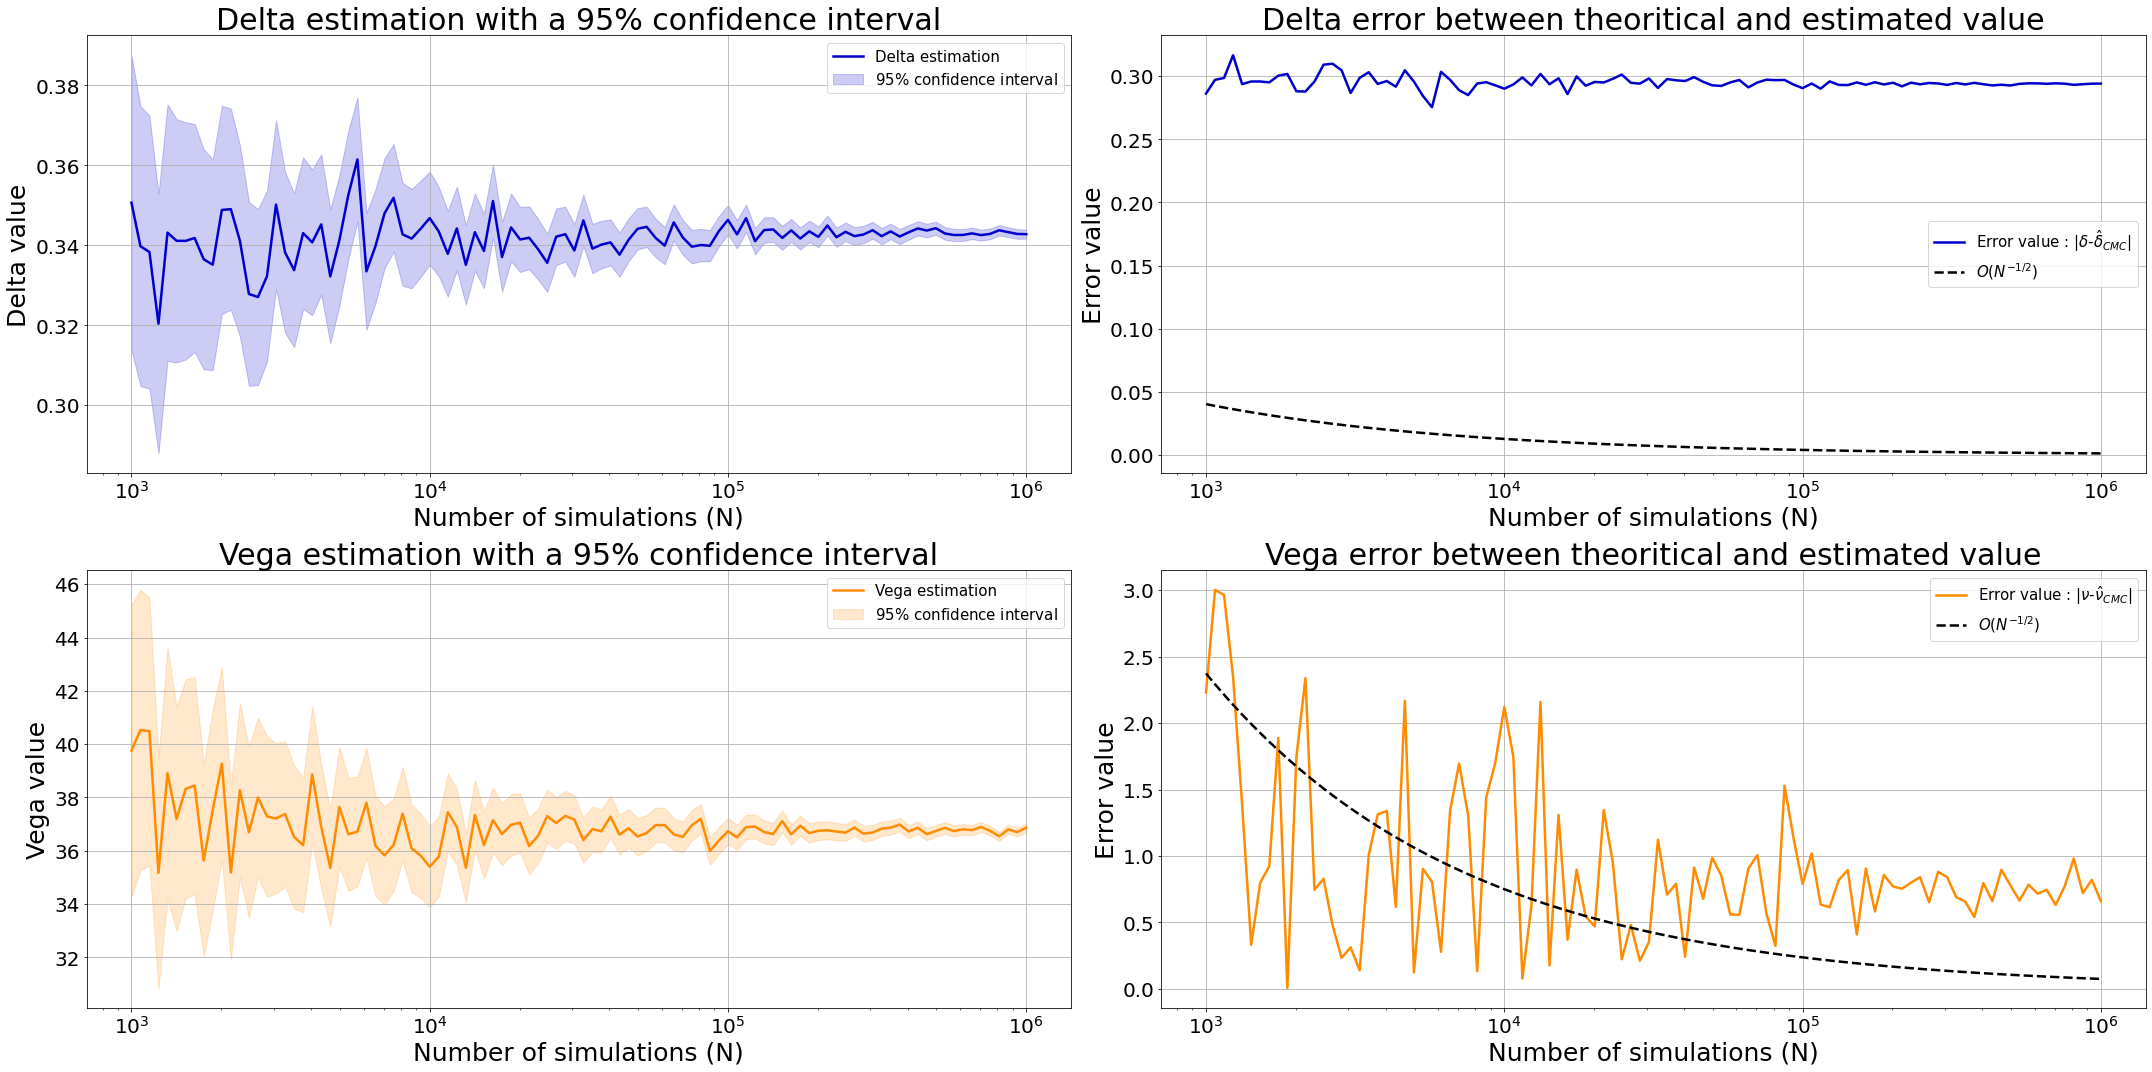

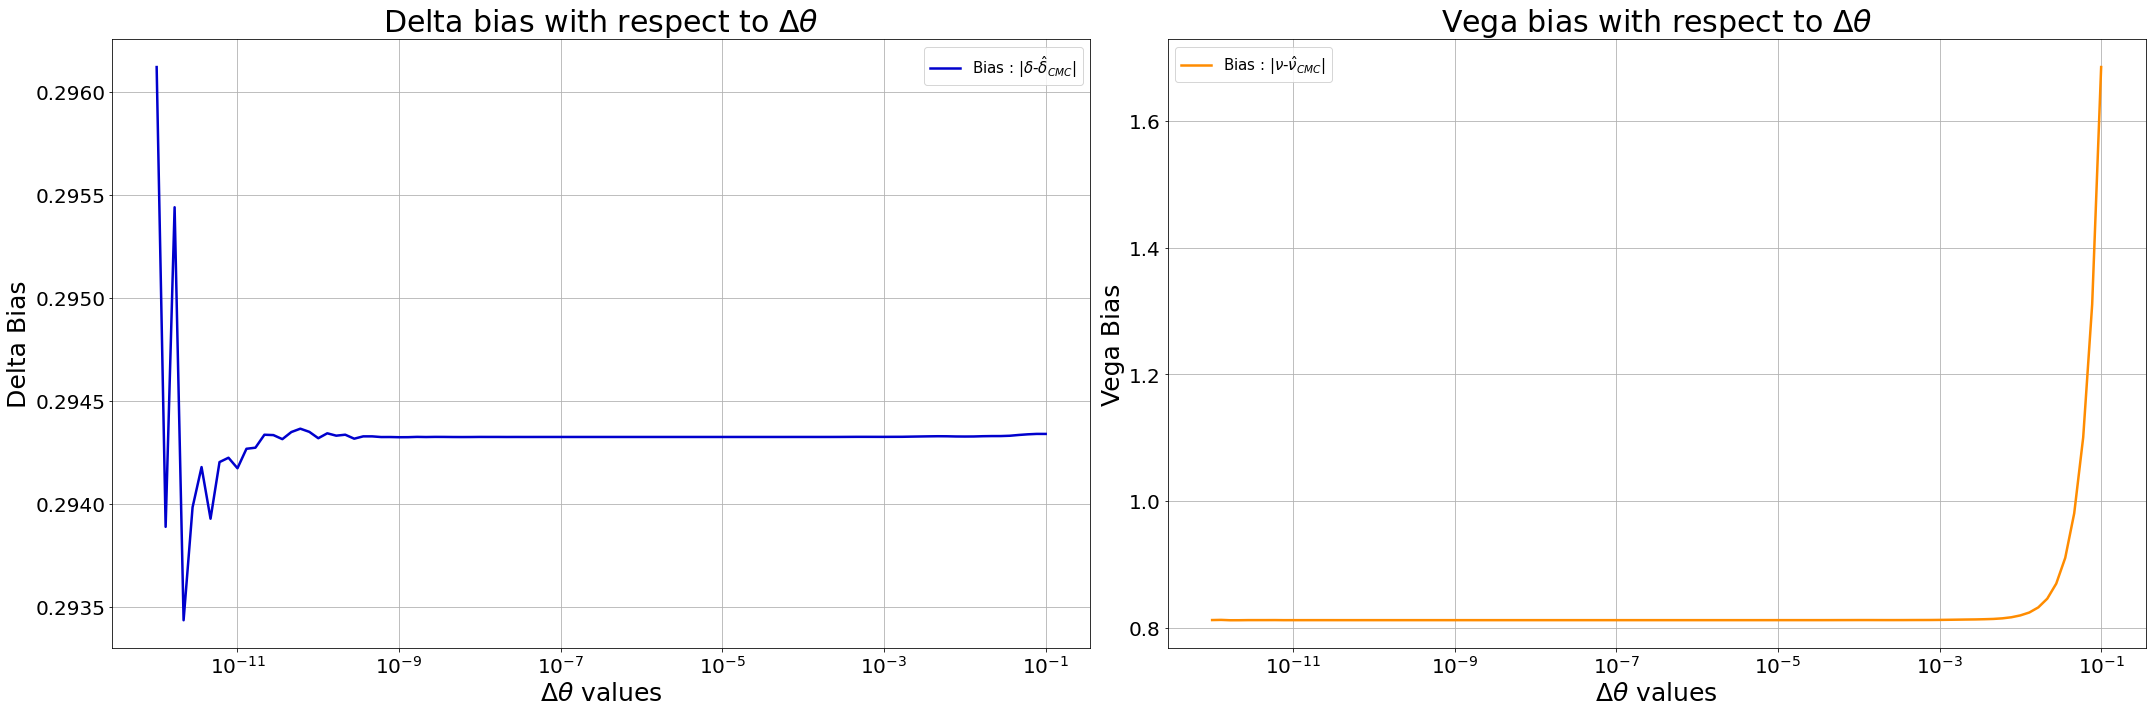

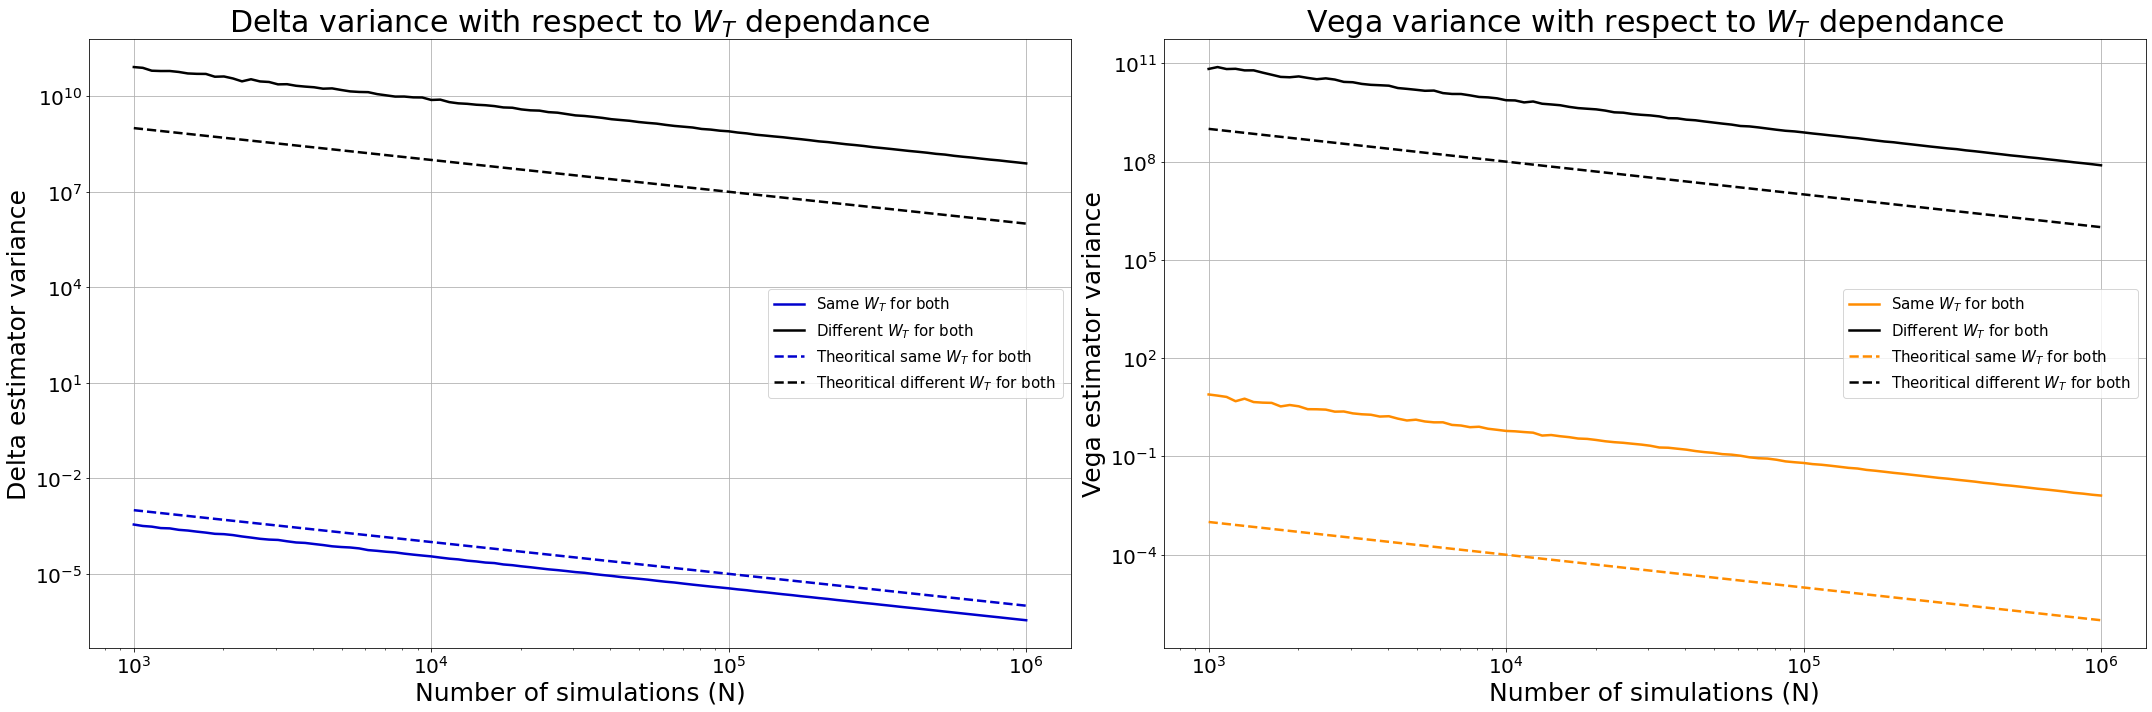

In [218]:
# Results Finite difference method

d1 : float = (np.log(S_0/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
real_val : dict = {"delta":st.norm.cdf(d1),"vega":S_0*np.sqrt(T)*st.norm.pdf(d1),"gamma":st.norm.pdf(d1)/(sig*S_0*np.sqrt(T))}
    
print("Estimated delta value with biggest N: ", finite_methods_dict["delta"][-1,0])
print("real delta value : ",real_val["delta"])
print("Variance of the delta estimator with N=10^6: ", finite_methods_dict["delta"][-1,1] **2)

print("Estimated vega value with biggest N: ", finite_methods_dict["vega"][-1,0])
print("real vega value : ",real_val["vega"])
print("Variance of the vega estimator with N=10^6: ", finite_methods_dict["vega"][-1,1] **2)

#print("Estimated gamma value with biggest N: ", finite_methods_dict["gamma"][-1,0])
#print("real gamma value : ",real_val["gamma"])

fig, ax = plt.subplots(len(greeks[:-1]),2,figsize=(30,15)) #Variation of N
fig2, ax2 = plt.subplots(1,len(greeks[:-1]),figsize=(30,10)) #Variation of dtheta
fig3, ax3 = plt.subplots(1,len(greeks[:-1]),figsize=(30,10)) #With or without iid W_T


colors = {"delta":"mediumblue","vega":"darkorange","gamma":"#6096BA"}
symbols = {"delta":[r"$\delta$",r"$\hat{\delta}_{CMC}$"],"vega":[r"$\nu$",r"$\hat{\nu}_{CMC}$"],"gamma":[r"$\gamma$",r"$\hat{\gamma}_{CMC}$"]}

for idx,greek in enumerate(greeks[:-1]):
    
    # Confidence interval and mean plot
    
    ax[idx,0].plot(n_elem,finite_methods_dict[greek][:,0],label=greek.capitalize() + " estimation",c=colors[greek],lw=2.5)
    ax[idx,0].fill_between(n_elem, finite_methods_dict[greek][:,0] - 1.96*finite_methods_dict[greek][:,1]/np.sqrt(n_elem), 
                                 finite_methods_dict[greek][:,0] + 1.96*finite_methods_dict[greek][:,1]/np.sqrt(n_elem),
                           alpha=0.2,label=r"$95$% confidence interval",color=colors[greek])
    ax[idx,0].set_title(f"{greek.capitalize()} estimation with a 95% confidence interval",fontsize=30)
    ax[idx,0].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,0].set_ylabel(f"{greek.capitalize()} value",size=25)
    ax[idx,0].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,0].legend(fontsize=15)
    ax[idx,0].set_xscale("log")
    ax[idx,0].grid()
    
    
    # Error of the estimation
    ax[idx,1].plot(n_elem,np.abs(real_val[greek]-finite_methods_dict[greek][:,0]),lw=2.5,
                   label=f"Error value : |{symbols[greek][0]}-{symbols[greek][1]}|",c=colors[greek])
    ax[idx,1].plot(n_elem,2*real_val[greek]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    ax[idx,1].set_title(f"{greek.capitalize()} error between theoritical and estimated value",fontsize=30)
    ax[idx,1].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,1].set_ylabel(f"Error value",size=25)
    ax[idx,1].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,1].legend(fontsize=15)
    ax[idx,1].set_xscale("log")
    ax[idx,1].grid()
    
    
    # Bias wrt delta theta
    ax2[idx].plot(dthetas,np.abs(finite_methods_dthetas[greek][:,0] - real_val[greek]),
                  label=f"Bias : |{symbols[greek][0]}-{symbols[greek][1]}|",c=colors[greek],lw=2.5)
    ax2[idx].set_title(f"{greek.capitalize()}" + r" bias with respect to $\Delta \theta$",fontsize=30)
    ax2[idx].set_xlabel(r"$\Delta \theta $ values",size=25)
    ax2[idx].set_ylabel(f"{greek.capitalize()} Bias",size=25)
    ax2[idx].tick_params(axis='both', which='major', labelsize=20)
    ax2[idx].legend(fontsize=15)
    ax2[idx].set_xscale("log")
    ax2[idx].grid()
    
    # Variance of estimator wrt independance of W_T
    ax3[idx].plot(n_elem,finite_methods_dict[greek][:,1]**2/n_elem,
                  label="Same $W_T$ for both ",c=colors[greek],lw=2.5)
    ax3[idx].plot(n_elem,finite_methods_dict_W_T_diff[greek][:,1]**2/n_elem,
                  label="Different $W_T$ for both ",c="black",lw=2.5)
    ax3[idx].plot(n_elem,1/n_elem,
              label="Theoritical same $W_T$ for both ",c=colors[greek],ls="--",lw=2.5)

    ax3[idx].plot(n_elem,1/(n_elem*dtheta**2),
                  label="Theoritical different $W_T$ for both ",c="black",ls="--",lw=2.5)
    ax3[idx].set_title(f"{greek.capitalize()}" + r" variance with respect to $W_T$ dependance",fontsize=30)
    ax3[idx].set_xlabel("Number of simulations (N)",size=25)
    ax3[idx].set_ylabel(f"{greek.capitalize()} estimator variance",size=25)
    ax3[idx].tick_params(axis='both', which='major', labelsize=20)
    ax3[idx].legend(fontsize=15)
    ax3[idx].set_xscale("log")
    ax3[idx].set_yscale("log")
    ax3[idx].grid()
    
    
    
fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

#fig.savefig("./plots/3.1/FD_delta_vega_estimation.png")
#fig2.savefig("./plots/3.1/FD_bias_wrt_theta.png")
#fig3.savefig("./plots/3.1/FD_independance_W_T.png")

Explications Finite difference method:

Pour delta et vega : $\frac{\partial I}{\partial \theta} \approx \frac{I(\theta+\Delta\theta)-I(\theta-\Delta\theta)}{2 \Delta\theta} = \mathbb{E}[\frac{f(S_T^{\theta+\Delta\theta})-f(S_T^{\theta-\Delta\theta})}{(2 \Delta\theta)}]$ that was estimated with the Crude-Monte Carlo estimator by distributing the expectation on both functions. 


For the variance of $\frac{\partial I}{\partial \theta}$, we get : $Var(\frac{f(S_T^{\theta+\Delta\theta})-f(S_T^{\theta-\Delta\theta})}{(2 \Delta\theta)}) = \frac{1}{4(\Delta\theta)^2}Var(f(S_T^{\theta+\Delta\theta})-f(S_T^{\theta-\Delta\theta})) = \frac{1}{4(\Delta\theta)^2}[Var(f(S_T^{\theta+\Delta\theta})) + Var(f(S_T^{\theta-\Delta\theta})) - 2Cov(f(S_T^{\theta+\Delta\theta}),f(S_T^{\theta-\Delta\theta})]$.

Comments :

Quelle valeur de $\Delta \theta$ choisir?

In [201]:
# Pathwise derivative
# Todo : dériver le payoff et le modèle BS pour S_T

dSdtheta = {"delta":dS_dS0,"vega":dS_dsig,"gamma":dS_dS0}

pathwise_dict = {}
for greek in greeks:
    pathwise_dict[greek] = np.array([pathwise_deriv(dC_payoff,ddC_payoff,params,dSdtheta[greek],greek, n) for idx,n in enumerate(n_elem)])

Estimated delta value with biggest N:  0.3424873905297203
real delta value :  0.6368306511756191
Variance of the delta estimator with N=10^6:  0.34901038380864435
Estimated vega value with biggest N:  36.83082651237865
real vega value :  37.52403469169379
Variance of the vega estimator with N=10^6:  6397.442101875231
Estimated gamma value with biggest N:  0.0002917634071444082
real gamma value :  0.007504806938338758
Variance of the gamma estimator with N=10^6:  0.0003995669233229895


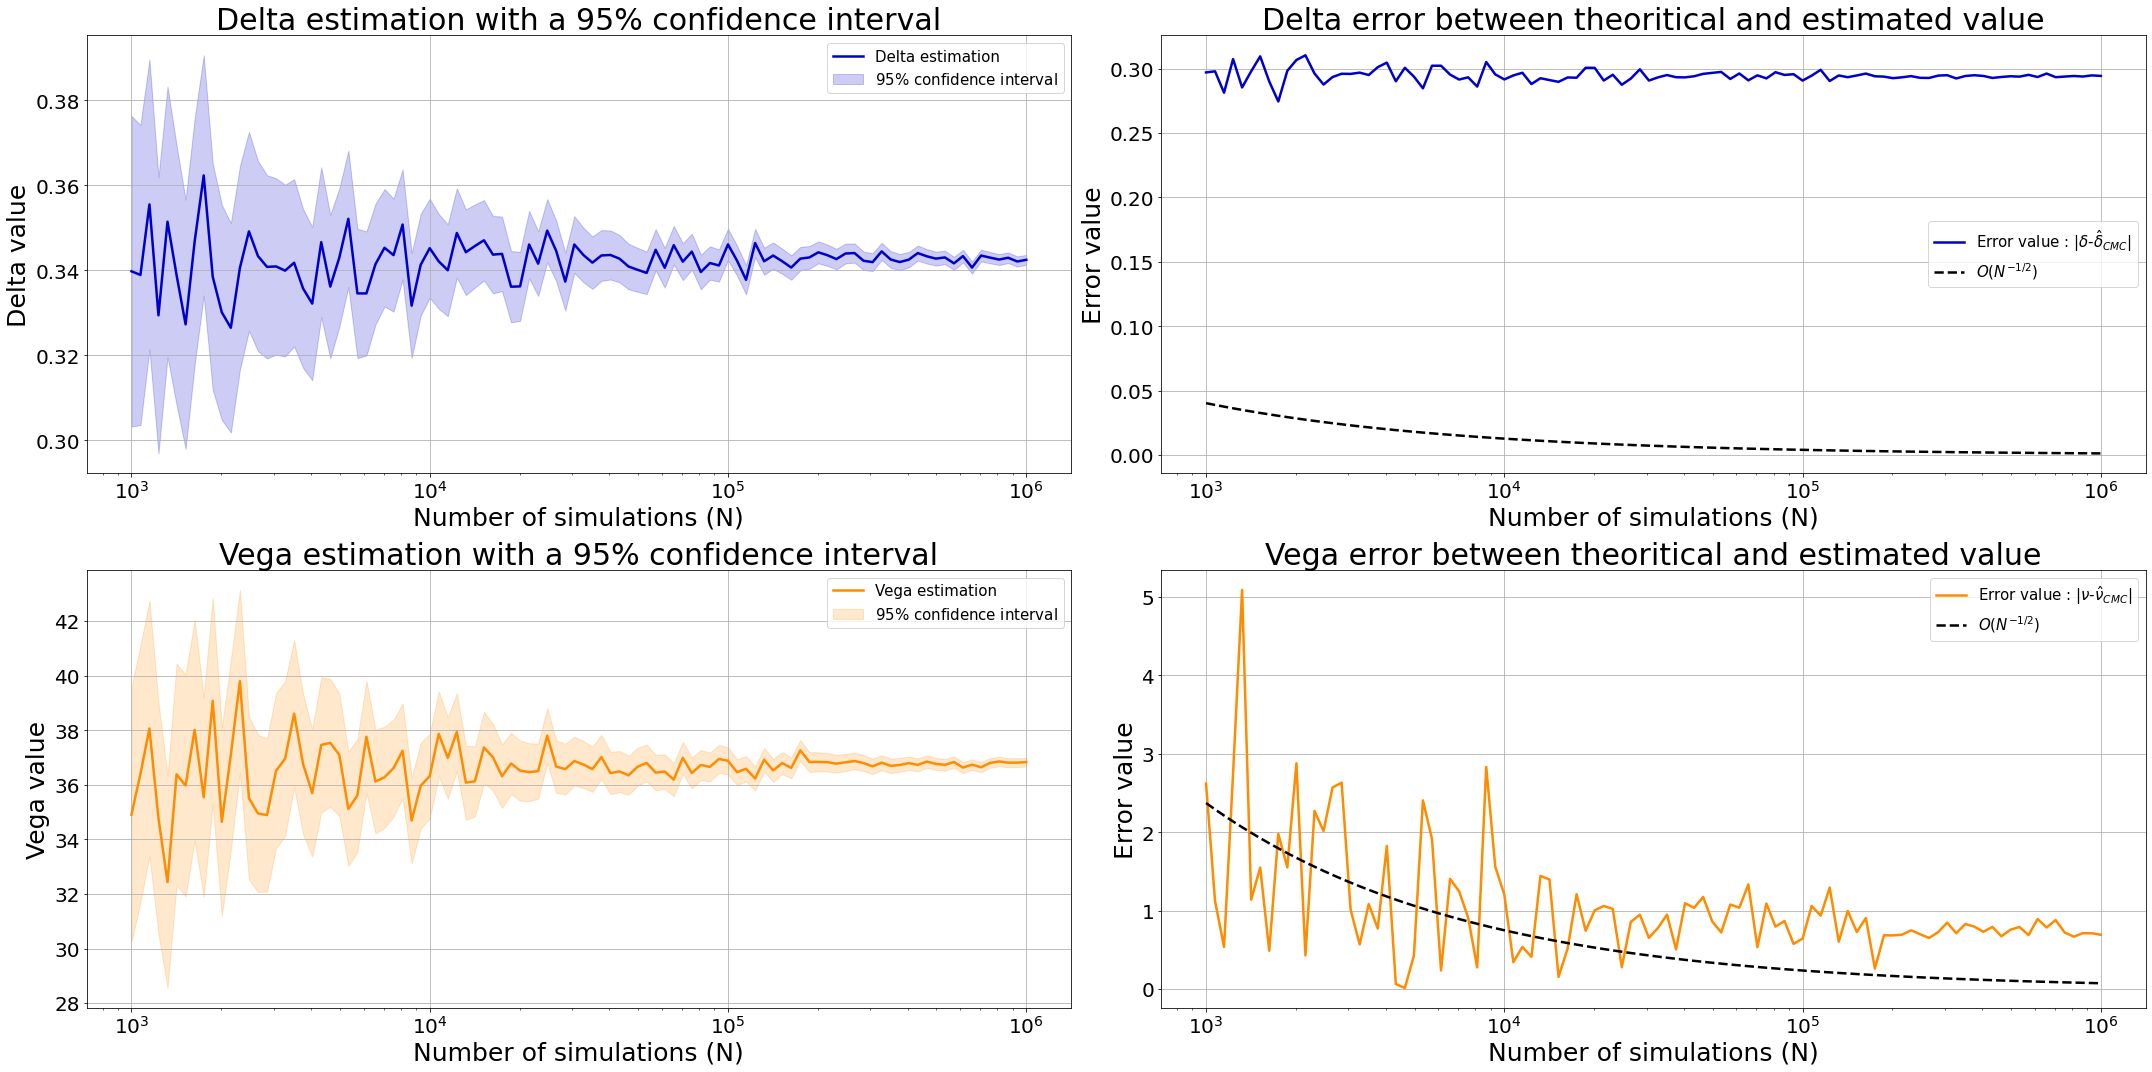

In [219]:
# Pathwise derivative

print("Estimated delta value with biggest N: ", pathwise_dict["delta"][-1,0])
print("real delta value : ",real_val["delta"])
print("Variance of the delta estimator with N=10^6: ", pathwise_dict["delta"][-1,1] **2)

print("Estimated vega value with biggest N: ", pathwise_dict["vega"][-1,0])
print("real vega value : ",real_val["vega"])
print("Variance of the vega estimator with N=10^6: ", pathwise_dict["vega"][-1,1] **2)

print("Estimated gamma value with biggest N: ", pathwise_dict["gamma"][-1,0])
print("real gamma value : ",real_val["gamma"])
print("Variance of the gamma estimator with N=10^6: ", pathwise_dict["gamma"][-1,1] **2)

fig, ax = plt.subplots(len(greeks)-1,2,figsize=(30,15)) #Variation of N


for idx,greek in enumerate(greeks[:-1]):
    
    # Confidence interval and mean plot
    
    ax[idx,0].plot(n_elem,pathwise_dict[greek][:,0],label=greek.capitalize() + " estimation",c=colors[greek],lw=2.5)
    ax[idx,0].fill_between(n_elem, pathwise_dict[greek][:,0] - 1.96*pathwise_dict[greek][:,1]/np.sqrt(n_elem), 
                                 pathwise_dict[greek][:,0] + 1.96*pathwise_dict[greek][:,1]/np.sqrt(n_elem),
                           alpha=0.2,label=r"$95$% confidence interval",color=colors[greek])
    ax[idx,0].set_title(f"{greek.capitalize()} estimation with a 95% confidence interval",fontsize=30)
    ax[idx,0].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,0].set_ylabel(f"{greek.capitalize()} value",size=25)
    ax[idx,0].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,0].legend(fontsize=15)
    ax[idx,0].set_xscale("log")
    ax[idx,0].grid()
    
    
    # Error of the estimation
    ax[idx,1].plot(n_elem,np.abs(real_val[greek]-pathwise_dict[greek][:,0]),lw=2.5,
                   label=f"Error value : |{symbols[greek][0]}-{symbols[greek][1]}|",c=colors[greek])
    ax[idx,1].plot(n_elem,2*real_val[greek]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    ax[idx,1].set_title(f"{greek.capitalize()} error between theoritical and estimated value",fontsize=30)
    ax[idx,1].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,1].set_ylabel(f"Error value",size=25)
    ax[idx,1].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,1].legend(fontsize=15)
    ax[idx,1].set_xscale("log")
    ax[idx,1].grid()
    
fig.tight_layout()
fig.savefig("./plots/3.1/PD_delta_vega_estimation.png")

Comments:

On est toujours mauvais pour le gamma mais au moins ça converge vers quelque chose. Les erreurs dont pas idéales je trouve niveau convergence rate

Likelihood ratio : compute $\frac{\partial I}{\partial \theta} = \mathbb{E}[f(S_T)\frac{\dot{p_\theta}(s)}{p_{S_T}(s)}]$ where $\frac{\dot{p_\theta}(s)}{p_{S_T}(s)} = \frac{\partial}{\partial \theta} (\log p_{S_T}(s)) = \frac{\partial}{\partial \theta} (-log(s\sigma\sqrt{2\pi T})) - \frac{1}{2}\frac{\partial}{\partial \theta}\left(\frac{\log(s/S_0)-(r-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}\right)^2$

Thus, we have for $\theta = S_0, \sigma$:

$\frac{\dot{p_{S_0}}(s)}{p_{S_T}(s)} = - \left(\frac{\log(s/S_0)-(r-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}\right)\frac{1}{\sigma\sqrt{T}}\frac{\partial}{\partial S_0}\log(\frac{s}{S_0}) = - \left(\frac{\log(s/S_0)-(r-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}\right)\frac{1}{\sigma\sqrt{T}}\frac{S_0}{s}\frac{-s}{S_0^2} = \frac{1}{S_0\sigma\sqrt{T}}\left(\frac{\log(s/S_0)-(r-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}\right)$

$\frac{\dot{p_{\sigma}}(s)}{p_{S_T}(s)} = \frac{-1}{\sigma} - \left(\frac{\log(s/S_0)-(r-\frac{1}{2}\sigma^2)T)}{\sigma\sqrt{T}}\right)\left(\frac{rT-\log(s/S_0)}{\sigma^2\sqrt{T}}+\frac{\sqrt{T}}{2}\right)$


In [203]:
dpdS0 = lambda x,p: 1/(p[1]*p[3]**2*p[0])*(np.log(x/p[1])-(p[2]-0.5*p[3]**2)*p[0])

dpdSigma = lambda x,p: -1/p[3] - 1/(p[3]*np.sqrt(p[0]))*(np.log(x/p[1])-(p[2]-0.5*p[3]**2)*p[0])*\
                        ((p[2]*p[0]-np.log(x/p[1]))/(np.sqrt(p[0])*p[3]**2) + 0.5*np.sqrt(p[0]))

dp_tot = {"delta":dpdS0,"vega":dpdSigma}

LR_dict = {}
for greek in greeks[:-1]:
    LR_dict[greek] = np.array([likelihood_ratio(C_payoff,dp_tot[greek],params,greek, n) for idx,n in enumerate(n_elem)])

Estimated delta value with biggest N:  0.3420033977253286
real delta value :  0.6368306511756191
Variance of the delta estimator with N=10^6:  1.2522826834778298
Estimated vega value with biggest N:  37.00102927117297
real vega value :  37.52403469169379
Variance of the vega estimator with N=10^6:  51001.010406012174


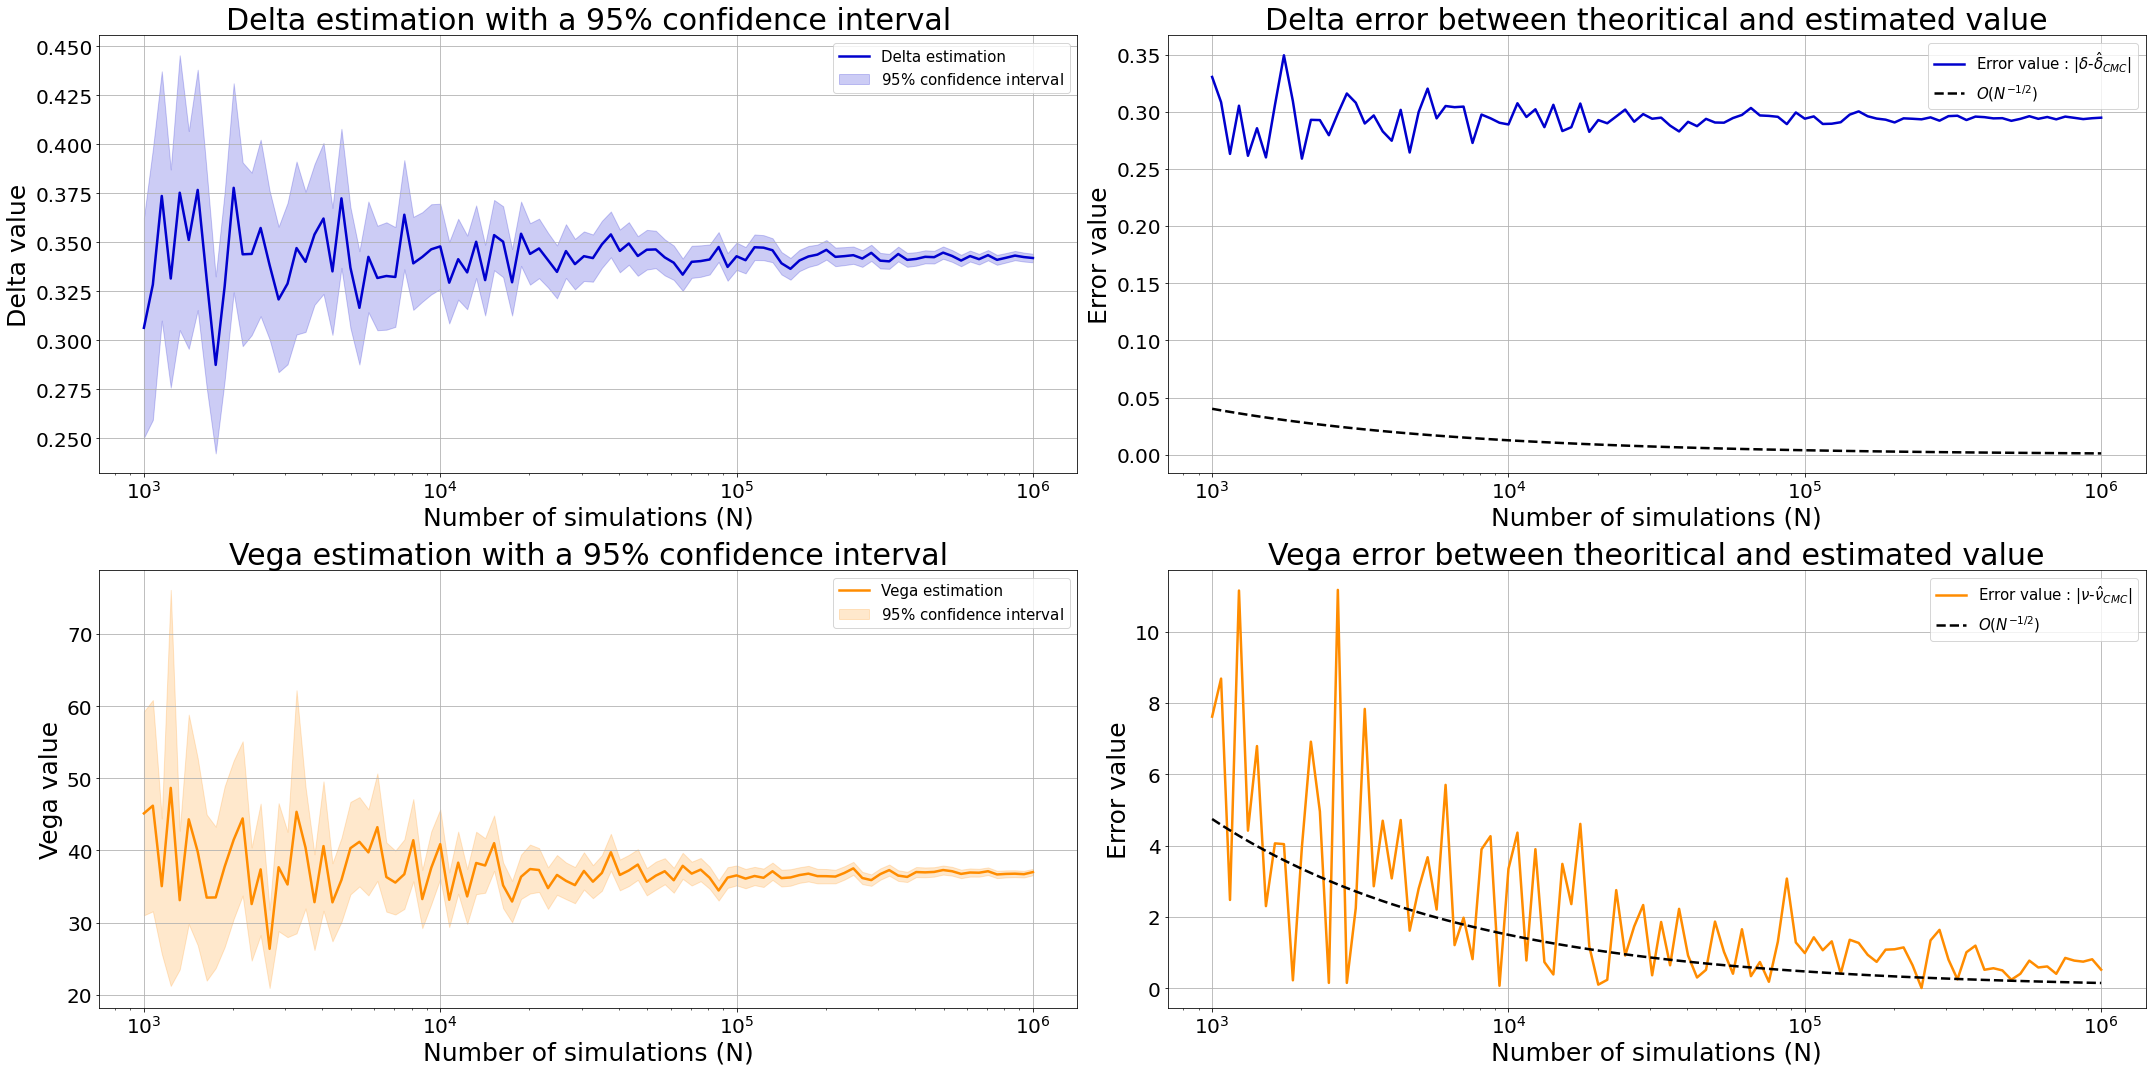

In [217]:
# Likelihood Ratio

print("Estimated delta value with biggest N: ", LR_dict["delta"][-1,0])
print("real delta value : ",real_val["delta"])
print("Variance of the delta estimator with N=10^6: ", LR_dict["delta"][-1,1] **2)

print("Estimated vega value with biggest N: ", LR_dict["vega"][-1,0])
print("real vega value : ",real_val["vega"])
print("Variance of the vega estimator with N=10^6: ", LR_dict["vega"][-1,1] **2)


fig, ax = plt.subplots(len(greeks)-1,2,figsize=(30,15))

for idx,greek in enumerate(greeks[:-1]):
    
    # Confidence interval and mean plot
    
    ax[idx,0].plot(n_elem,LR_dict[greek][:,0],label=greek.capitalize() + " estimation",c=colors[greek],lw=2.5)
    ax[idx,0].fill_between(n_elem, LR_dict[greek][:,0] - 1.96*LR_dict[greek][:,1]/np.sqrt(n_elem), 
                                 LR_dict[greek][:,0] + 1.96*LR_dict[greek][:,1]/np.sqrt(n_elem),
                           alpha=0.2,label=r"$95$% confidence interval",color=colors[greek])
    ax[idx,0].set_title(f"{greek.capitalize()} estimation with a 95% confidence interval",fontsize=30)
    ax[idx,0].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,0].set_ylabel(f"{greek.capitalize()} value",size=25)
    ax[idx,0].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,0].legend(fontsize=15)
    ax[idx,0].set_xscale("log")
    ax[idx,0].grid()
    
    
    # Error of the estimation
    ax[idx,1].plot(n_elem,np.abs(real_val[greek]-LR_dict[greek][:,0]),lw=2.5,
                   label=f"Error value : |{symbols[greek][0]}-{symbols[greek][1]}|",c=colors[greek])
    if greek == "delta":
        ax[idx,1].plot(n_elem,2*real_val[greek]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    else:
        ax[idx,1].plot(n_elem,4*real_val[greek]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    ax[idx,1].set_title(f"{greek.capitalize()} error between theoritical and estimated value",fontsize=30)
    ax[idx,1].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,1].set_ylabel(f"Error value",size=25)
    ax[idx,1].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,1].legend(fontsize=15)
    ax[idx,1].set_xscale("log")
    ax[idx,1].grid()
fig.tight_layout()
fig.savefig("./plots/3.1/LR_delta_vega_estimation.png")

### 3.2.b Estimation of $\gamma$

##### With twice the likelihood ratio:

We have $\frac{\partial^2 I}{\partial S_0 ^2} = \int_0^\infty f(s) \frac{\partial^2 p_{S_T}(s)}{S_0^2} ds = \mathbb{E}\left[ f(S_T) \frac{\ddot{p}_{S_0}(s)}{p_{S_T}(s)} \right] $

Where (denoted ddpdS0 in the code)

$\frac{\ddot{p}_{S_0}(s)}{p_{S_T}(s)}$
$= -\frac{1}{S_0 ^2 \sigma^2 T}\left(1+\log(\frac{s}{S_0}) - (r - \frac{1}{2}\sigma^2)T \right) + \left( \frac{1}{S_0\sigma\sqrt{T}}\left(\frac{\log(s/S_0)-(r-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}\right) \right)^2$

##### With Pathwise then Likelihood Ratio:

We have $\frac{\partial^2 I}{\partial S_0 ^2} = \frac{\partial}{\partial S_0} \tilde{I}$, where $\tilde{I} =\mathbb{E}[g(S_T)] = \frac{\partial I}{\partial S_0}$

where $g(S_T) = f'(S_T) \frac{\partial S_T}{\partial S_0}$ so $g(S_T) = e^{-rT} 1_{\{S_T \ge K\}} e^{(r-\frac{1}{2}\sigma^2)T +\sigma W_T} = 1_{\{S_T \ge K\}} e^{-\frac{1}{2}\sigma^2T +\sigma W_T}$

Pour le code, on doit poser $g(S_T) = e^{-rT} 1_{\{S_T \ge K\}} \frac{S_T}{S_0}$ comme ça on ne dépend que de $S_T$ :) 

Hence, we apply the likelihood ratio to the payoff $g$ instead of $f$.

##### With LR then Pathwise:

$\frac{\partial^2 I}{\partial S_0 ^2} = \frac{\partial}{\partial S_0} \mathbb{E}\left[ f(S_T)\frac{\dot{p}_{S_0}(S_T)}{p_{S_T}(S_T)} \right] = \frac{\partial}{\partial S_0} \mathbb{E}[h(S_T)]$
where $h(s) = f(s)\frac{\dot{p}_{S_0}(s)}{p_{S_T}(s)}$. Hence,

$h'(s) = f'(s) \frac{\dot{p}_{S_0}(s)}{p_{S_T}(s)} + f(s) \frac{\partial}{\partial s} \left(\frac{\dot{p}_{S_0}(s)}{p_{S_T}(s)}\right) = f'(s) \frac{\dot{p}_{S_0}(s)}{p_{S_T}(s)} + f(s)\frac{1}{S_0 \sigma^2 T s}$

which gives us : 

$\frac{\partial^2 I}{\partial S_0 ^2} = \frac{\partial}{\partial S_0} \mathbb{E}[h(S_T)] = \mathbb{E}[h'(S_T)\frac{\partial S_T}{\partial S_0}] = \mathbb{E}[h'(S_T)\frac{S_T}{S_0}]$

Questions sans encore de réponses: 

Comment dériver le payoff avec la fonction indicatrice? -> faire avec le delta je suppose et poser S_T = K


Quand on applique la PD method, puis la LR method, j'ai utilisé le même likelihood ratio car si on repart de zéro, la fonction f n'affecte en rien le LR... Mais l'estimation est complètement erronée et c'est peut-être à cause de ca. 
Ou alors, l'erreur peut venir du fait que dans les fonctions "lambda" la variable x est utilisée soit pour S_T soit pour W_T et je me suis peut-etre perdu dans ca... -> more or less fixed en posant $S_T$ partout pour $g(S_T)$ :)

In [205]:
gamma_est = {}

print("Valeur réelle de gamma à estimer: ",real_val["gamma"])

#Using twice the likelihood Ratio method
ddpdS0 = lambda x,p: -(1 +np.log(x/p[1]) - (p[2] -0.5*p[3]**2)*p[0])/(p[0] * p[1]**2 * p[3]**2) + (1/(p[1]*p[3]**2*p[0])*(np.log(x/p[1])-(p[2]-0.5*p[3]**2)*p[0]))**2


gamma_est["LRLR"] = np.array([likelihood_ratio(C_payoff,ddpdS0,params,"gamma", n) for idx,n in enumerate(n_elem)])

print("the approximation of gamma with twice the LR method is ",gamma_est["LRLR"][-1,0])

#using pathwise and then likelihood ratio (PDLR)

#gfunc = lambda x,p : (p[1]*np.exp((p[2]-0.5*p[3]**2)*p[0] + p[3]*x) > p[4])*np.exp(-0.5*p[3]**2 *p[0] + p[3]*x) #ATTENTION : (x > p[4]) or (p[1]*np.exp((p[2]-0.5*p[3]**2)*p[0] + p[3]*x) > p[4]) = (S_T > K)
#Depends if x= S_T or W_T, here the most logic would be x = W_T... non pas d'accord


# [T,S_0,r,sig,K]

g = lambda x,p : np.exp(-p[0]*p[2])*(x >= p[4])*x/p[1]

#Needs definition of dpdS0 defined above when applying LR method for Delta
#Or uncomment this for local test 
dpdS0 = lambda x,p: 1/(p[1]*p[3]**2*p[0])*(np.log(x/p[1])-(p[2]-0.5*p[3]**2)*p[0])

gamma_est["PDLR"] = np.array([likelihood_ratio(g,dpdS0,params,"gamma", n) for idx,n in enumerate(n_elem)])

print("the approximation of gamma with Pathwise derivative then the LR method is ",gamma_est["PDLR"][-1,0])

#Using LR then pathwise derivative:
dS_dS0_test = lambda x,p : np.exp((p[2]-0.5*p[3]**2)*p[0]+p[3]*x) # x = W_T

hfunc = lambda x,p : C_payoff(x,p) * dpdS0(x,p)
#dhfunc = lambda x,p : dC_payoff(x,p) * dpdS0(x,p) + C_payoff(x,p)/(p[1]*p[3]**2 * p[0]*x)
dhfunc = lambda x,p : np.exp(-p[2]*p[0]) * (x >= p[4]) * ((x-p[4])/x + np.log(x/p[1]) - p[0]*(p[2]-0.5*p[3]**2)) / (p[1]*p[0]*p[3]**2)

gamma_est["LRPD"] = np.array([pathwise_deriv(dhfunc,None,params,dS_dS0_test,"delta", n) for idx,n in enumerate(n_elem)])

print("the approximation of gamma with LR then pathwise derivative ",gamma_est["LRPD"][-1,0])



#Ca implique que le problème vient du pathwise derivative. Les deux expectations sont différentes, ca veut dire 
#qu'on n'a pas le droit d'échanher derivee et expectation.

[mean, std] = finite_difference(hfunc,params,dtheta,"delta", n_elem[-1],False)
print("the mean is " + str(mean))




Valeur réelle de gamma à estimer:  0.01470543633560505
the approximation of gamma with twice the LR method is  0.014684556266525432
the approximation of gamma with Pathwise derivative then the LR method is  0.01819221626941968
the approximation of gamma with LR then pathwise derivative  0.026179308790887118
the mean is 0.0146999260920157


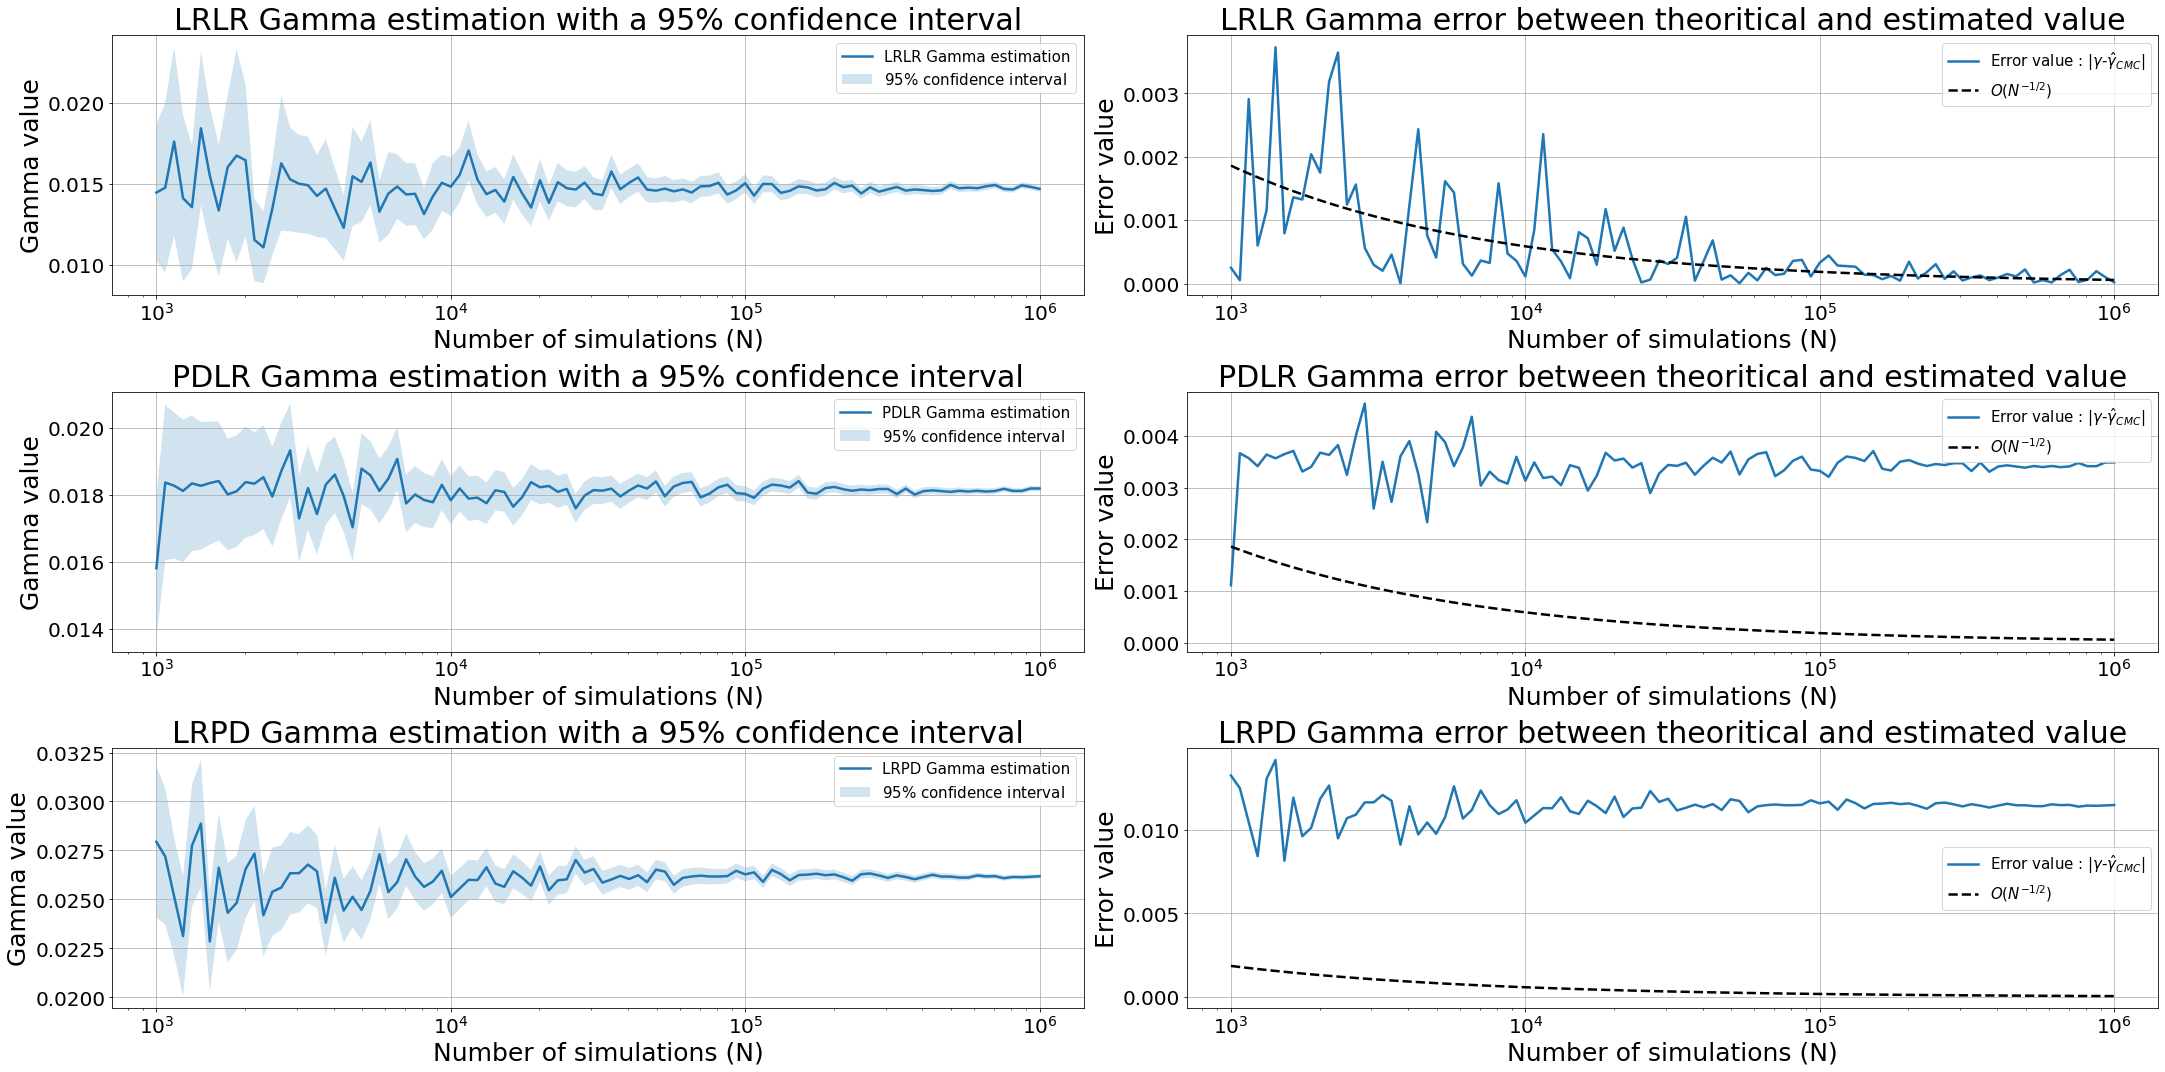

In [206]:
fig, ax = plt.subplots(len(list(gamma_est.keys())),2,figsize=(30,15))

for idx, method in enumerate(list(gamma_est.keys())):    
    # Confidence interval and mean plot
    
    ax[idx,0].plot(n_elem,gamma_est[method][:,0],label=method+" Gamma estimation",lw=2.5)
    ax[idx,0].fill_between(n_elem, gamma_est[method][:,0] - 1.96*gamma_est[method][:,1]/np.sqrt(n_elem), 
                                 gamma_est[method][:,0] + 1.96*gamma_est[method][:,1]/np.sqrt(n_elem),
                           alpha=0.2,label=r"$95$% confidence interval")
    ax[idx,0].set_title(method+" Gamma estimation with a 95% confidence interval",fontsize=30)
    ax[idx,0].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,0].set_ylabel("Gamma value",size=25)
    ax[idx,0].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,0].legend(fontsize=15)
    ax[idx,0].set_xscale("log")
    ax[idx,0].grid()
    
    # Error of the estimation
    ax[idx,1].plot(n_elem,np.abs(real_val["gamma"]-gamma_est[method][:,0]),lw=2.5,
                   label=f"Error value : |{symbols['gamma'][0]}-{symbols['gamma'][1]}|")
    ax[idx,1].plot(n_elem,4*real_val["gamma"]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    ax[idx,1].set_title(method+" Gamma error between theoritical and estimated value",fontsize=30)
    ax[idx,1].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,1].set_ylabel("Error value",size=25)
    ax[idx,1].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,1].legend(fontsize=15)
    ax[idx,1].set_xscale("log")
    ax[idx,1].grid()
    
fig.tight_layout()

fig.savefig("./plots/3.2/estimations.png")

Notes après discussion:

La dérivée seconde avec le gamma -> on obtiendra un delta et ducoup ça sera une cst par rapport à S_T = K mais ça sera pas nul -> à implémenter

Bien vérifier qu'on a fait le changement avec l'erreur dans l'énoncé

## 3.2 Mixed estimators for Digital call option

$f_\epsilon(x) = min(1,max(0,\frac{x-K+\epsilon}{2\epsilon}))$

donc entre $-\infty$ et $x=K-\epsilon$, $f_\epsilon(x)= 0$, then it becomes $min(1,\frac{x-K+\epsilon}{2\epsilon})$, meaning that while $\frac{x-K+\epsilon}{2\epsilon} \le 1$, it has this value. This is the case when $x \le K + \epsilon$, which means :

\begin{equation}
    f_\epsilon(x)=
    \begin{cases}
      0 & \text{for}\ x \le K-\epsilon \\
      \frac{x-K+\epsilon}{2\epsilon} & \text{for}\ K-\epsilon \le x \le K+\epsilon \\
      1 & \text{for}\ x > K+\epsilon
    \end{cases}
\end{equation}


1) Apply pathwise differentiation for $\frac{\partial}{\partial S_0}\mathbb{E}[f_\epsilon(S_T)]$

$\frac{\partial}{\partial S_0}\mathbb{E}[f_\epsilon(S_T)] = \mathbb{E}[f'_\epsilon(S_T)\frac{\partial S_T}{\partial S_0}]$.

where:
\begin{equation}
    f'_\epsilon(x)=
    \begin{cases}
      0 & \text{for}\ x \le K-\epsilon \\
      \frac{1}{2\epsilon} & \text{for}\ K-\epsilon \le x \le K+\epsilon \\
      0 & \text{for}\ x > K+\epsilon
    \end{cases}
\end{equation}

and $\frac{\partial S_T}{\partial S_0}$ is defined as before


2) Apply likelihood ratio for $\frac{\partial}{\partial S_0}\mathbb{E}[h_\epsilon(x)]$

$\frac{\partial \mathbb{E}[h_\epsilon(S_T)]}{\partial S_0} = \int_0^\infty h_\epsilon(s) \frac{\partial}{\partial S_0}p_{S_T}(s)ds = \mathbb{E}[h_\epsilon(s)\frac{\dot{p}_{S_0}}{p_{S_T}}]$ 

Combining 1) and 2), one gets the delta approximation for the digital option $f$:

$\delta = e^{-rT}\left(  \mathbb{E}\left[f'_\epsilon(S_T)\frac{\partial S_T}{\partial S_0}\right] + \mathbb{E}\left[h_\epsilon(s)\frac{\dot{p}_{S_0}}{p_{S_T}}\right] \right)$


Now, to find the optimal allocation, we will try to minimize the total variance :

    - Pilot run with split in half

    - Calculate the total variance of the two estimators by adding their variances together.

    - Optimize the allocation of samples between the two estimators by minimizing the total variance.
    
    

$\text{Var}_{tot} = \text{Var}\left(e^{-rT}(\hat{\mu}_{PD}(f_{\epsilon}))+\text{Var}(\hat{\mu}_{LR}(h_{\epsilon}))\right) = e^{-2rT}\left(\frac{1}{m} \text{Var}(f'_\epsilon(S_T)\frac{\partial S_T}{\partial S_0}) + \frac{1}{N-m}\text{Var}(h_\epsilon(s)\frac{\dot{p}_{S_0}}{p_{S_T}})\right)$


$\frac{\partial}{\partial m} \text{Var}_{tot} = \frac{-1}{m^2} \text{Var}(f'_\epsilon(S_T)\frac{\partial S_T}{\partial S_0}) + \frac{1}{(N-m)^2}\text{Var}(h_\epsilon(s)\frac{\dot{p}_{S_0}}{p_{S_T}}) = 0 \Rightarrow m^* = N \frac{Var_f-\sqrt{Var_fVar_h}}{Var_f-Var_h}$ (the other root is > N)

##### Charles : Pourquoi on est sur que c'est un minimum ?

Car $\text{Var}_{tot}$ est convexe $\forall m \in (0,N)$ puisque $\frac{\partial^2}{\partial m^2} \text{Var}_{tot} = \frac{2}{m^3}\text{Var}(f'_\epsilon(S_T)\frac{\partial S_T}{\partial S_0}) + \frac{2}{(N-m)^3}\text{Var}(h_\epsilon(s)\frac{\dot{p}_{S_0}}{p_{S_T}}) \ge 0$ for $m \in (0,N)$.

In [207]:
# Parameters
eps : float = 20
S_0 : float = 100
K : float = 100
T : float = 0.25
r : float = 0.00125
params : list = [T,S_0,r,sig,K,eps]

func = lambda x,p : np.exp(-p[0]*p[2])*(x>p[4])

f_e = lambda x,p : np.minimum(np.ones(len(x)),np.maximum(np.zeros(len(x)),0.5*(x-p[4]+p[5])/p[5]))   
h_e = lambda x,p : (x>p[4])-f_e(x,p)

d_f_e = lambda x,p : 1/(2*p[5])*(x <= p[4]+p[5])*(p[4]-p[5] <= x)

N : int = 10**6

# Pilot run
    
pilot_PD_f_e = pathwise_deriv(d_f_e,None, params,dS_dS0,"delta", int(N/2))
pilot_LR_h_e = likelihood_ratio(h_e,dpdS0,params,"delta",int(N/2))

var_tot_pilot = lambda m : np.exp(-2*params[2]*params[0])*(pilot_PD_f_e[1]**2/m + pilot_LR_h_e[1]**2/(N-m))

print("Pilot Approximated delta for the binary option :", np.exp(-params[2]*params[0])*(pilot_PD_f_e[0]+pilot_LR_h_e[0]))
print("Pilot Total Variance of estimator : ", var_tot_pilot(N/2))
m_opt_list = [int(N*(pilot_PD_f_e[1] - np.sqrt(pilot_PD_f_e[1]*pilot_LR_h_e[1]))/(pilot_PD_f_e[1]-pilot_LR_h_e[1])),
              int(N*(pilot_PD_f_e[1] + np.sqrt(pilot_PD_f_e[1]*pilot_LR_h_e[1]))/(pilot_PD_f_e[1]-pilot_LR_h_e[1]))]


print(m_opt_list)


eligible = [(0 <= m_opt_list[0]) and (m_opt_list[0] <= N),
            (0 <= m_opt_list[1]) and (m_opt_list[1] <= N)]

if eligible == [False,False]:
    print("no optimal m found within bounds [0,N]")
    m_opt = N/2
    print("Setting m_opt = N/2")
elif eligible == [True,True]:
    print("Both are eligible, taking the least for var_tot")
    m_opt = m_opt_list[np.argmin([var_tot_pilot(m_opt_list[0]),var_tot_pilot(m_opt_list[1])])]
    print("Chosen : ",m_opt)
else:
    print("Only one eligible",eligible)
    m_opt = m_opt_list[0]*eligible[0] + m_opt_list[1]*eligible[1] # On prend que celui eligible
    print("Chosen : ",m_opt)

PD_f_e = pathwise_deriv(d_f_e,None, params,dS_dS0,"delta", m_opt)
LR_h_e = likelihood_ratio(h_e,dpdS0,params,"delta",N-m_opt)
print("Approximated delta for the binary option :", np.exp(-params[2]*params[0])*(PD_f_e[0]+LR_h_e[0]))
print("Total Variance of estimator : ",  np.exp(-2*params[2]*params[0])*(PD_f_e[1]**2/m_opt + LR_h_e[1]**2/(N-m_opt)))

Pilot Approximated delta for the binary option : 0.03186890376198577
Pilot Total Variance of estimator :  1.9246210976077628e-10
[541941, 6460754]
Only one eligible [True, False]
Chosen :  541941
Approximated delta for the binary option : 0.03183605867540272
Total Variance of estimator :  1.889473627396648e-10


In [208]:
epsilons = np.arange(0,80+1)
tot_var = np.zeros(len(epsilons))
run_params = params.copy()
for idx,ep in enumerate(epsilons):
    if ep != 0:
        run_params[5] = ep
        PD_f_e = pathwise_deriv(d_f_e,None, run_params,dS_dS0,"delta", m_opt)
        LR_h_e = likelihood_ratio(h_e,dpdS0,run_params,"delta",N-m_opt)
        tot_var[idx] = np.exp(-2*params[2]*params[0])*(PD_f_e[1]**2/m_opt + LR_h_e[1]**2/(N-m_opt))
    else:
        LR_f = likelihood_ratio(func,dpdS0,params,"delta",N)
        tot_var[idx] = LR_f[1]**2/N

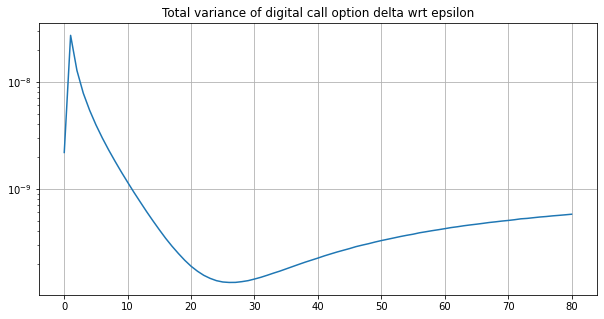

optimal epsilon found :  26


In [209]:
plt.figure(figsize=(10,5))
plt.plot(epsilons,tot_var)
plt.grid()
plt.yscale("log")
plt.title("Total variance of digital call option delta wrt epsilon")
plt.show()

print("optimal epsilon found : ",epsilons[np.argmin(tot_var)])

## 3.3 Path Dependent option

### For $\delta$:

$\delta = \frac{\partial}{\partial S_0} f(S_T) = \frac{\partial}{\partial \bar S_T} \frac{\partial \bar S_T}{\partial S_0}$
with $\frac{\partial}{\partial \bar S_T} = e^{-rT} 1_{\{\bar S_T > K\}}$ and $\frac{\partial \bar S_T}{\partial S_0} = \frac{\partial}{\partial S_0} \frac{1}{m}\sum_{i=1}^m S_{t_i} = \frac{1}{m}\sum_{i=1}^m \frac{\partial}{\partial S_0} S_{t_i} = \frac{1}{m}\sum_{i=1}^m \frac{S_{t_i}}{S_0} = \frac{\bar S_T}{S_0}$

Hence, $\delta = e^{-rT} 1_{\{\bar S_T > K\}} \frac{\bar S_T}{S_0} = u(\bar S_T)$

##### Pathwise Derivative:
We estimate $\delta = e^{-rT} \mathbb{E}\left[ 1_{\{\bar S_T > K\}} \frac{\bar S_T}{S_0} \right]$

(For a fixed $m$, simulate $N$ times $\bar S_T$ and work as in 3.2.c)

##### Likelihood Ratio:
Rien de particulier niveau maths, c'est juste la simulation qui doit être adaptée.

### For $\nu$:
##### Pathwise Derivative:
$\nu = \frac{\partial}{\partial \sigma} f(S_T) = \frac{\partial}{\partial \bar S_T} \frac{\partial \bar S_T}{\partial \sigma}$
with $\frac{\partial}{\partial \bar S_T} = e^{-rT} 1_{\{\bar S_T > K\}}$ and $\frac{\partial \bar S_T}{\partial \sigma} = \frac{\partial}{\partial \sigma} \frac{1}{m}\sum_{i=1}^m S_{t_i} = \frac{1}{m}\sum_{i=1}^m \frac{\partial}{\partial \sigma} S_{t_i}$

For each $t \in [0,T]$ we have :
$\frac{\partial S_t}{\partial \sigma} = (W_t -\sigma t) S_0 e^{(r-\frac{1}{2}\sigma^2)t+\sigma W_t} = (W_t-\sigma t) S_t = \frac{\log(S_t / S_0) - (r+\frac{1}{2}\sigma^2)t}{\sigma} S_t$.

We want to express it as a function of $S_t$ and the parameters, so we use the equality $(W_t-\sigma t) = \frac{\log(S_t / S_0) - (r+\frac{1}{2}\sigma^2)t}{\sigma}$ to get:

$\nu = \frac{1}{m}\sum_{i=1}^m \frac{\log(S_{t_i} / S_0) - (r+\frac{1}{2}\sigma^2)t_i}{\sigma} S_{t_i} =v(S_{t_1},...,S_{t_m})$

We estimate $\nu = \mathbb{E}\left[ \frac{1}{m}\sum_{i=1}^m \frac{\log(S_{t_i} / S_0) - (r+\frac{1}{2}\sigma^2)t_i}{\sigma} S_{t_i} \right]$

##### Likelihood Ratio:
Rien de particulier niveau maths, c'est juste la simulation qui doit être adaptée.

Pour la simulation, simuler N fois $\bar S_T$ risque d'être trop coûteux... 
J'avais pensé à Antithetic Variables pour réduire la variance et obtenir une bonne approximation avec moins de simulations (on fixe m et on simule ensuite N/2 fois \nu = \psi(S_{t_1},...,S_{t_m})$ qui semble satisfaire les conditions de l'Antithetic Variables algorithme. Mais ca risque de ne pas être suffisant...

A part la methode de variance reduction, il y a Cython qui semble permettre de réduire le temps d'execution (en simulant $S_{t_1},...,S_{t_m}$, $N$ fois comme expliqué sur ce site 
https://quantipy.wordpress.com/2017/08/19/pricing-asian-arithmetic-option-using-monte-carlo-simulations/  
Je ne sais pas si tu connais cette bibliothèque.
Si tu ne connaissais pas cette méthode et qu'on décide de l'utiliser, il faudra bien sûr citer cette source !

In [210]:
#Adapted Pathwise Derivative for Asian option
def asian_pathwise_deriv(params:list,derivative:str, n:int, m:int) -> np.array:
    """
    Pathwise derivative method to compute the derivative of I := E[f(S_T)] wrt theta where f(S_T) is the payoff of an asian option
        
    args:
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - derivative : either "delta" or "vega"
        - n : number of simulations for Monte-Carlo
        - m : number of samples in [0,T]
        
    returns : the estimated value of dI/dtheta by pathwise derivative and its standard deviation
    
    """
    
    if derivative not in ["delta","vega"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
    
    tt = np.linspace(params[0]/float(m), params[0], m) #tt = [t_1 = T/m,...,t_m = T] 
    St = lambda W,t,p : p[1]*np.exp((p[2]-0.5*p[3]**2)*t + p[3]*W) #Gives S_t given W_t and t

    barS_T = np.zeros(n)
    for i in range(n):
        #W_t : np.array = st.norm.rvs(loc=0,scale=np.sqrt(tt))
        barS_T[i] = np.mean(St(st.norm.rvs(loc=0,scale=np.sqrt(tt)),tt,params))
        
    #ufunc is a function of barS_T corresponds to u in the above theoretical computations
    ufunc = lambda x,p : np.exp(-p[2]*p[0]) * (x>p[4]) * x/p[1]
    
    if derivative == "delta":
        func = ufunc
    
    return CMC_estimator(func,barS_T,params)


In [211]:
# Parameters
T : float = 1
S_0 : float = 100
K : float = 100
r : float = 0.05
sig : float = 0.5
params : list = [T,S_0,r,sig,K]

N : int = 100000 
m : int = 100
[asian_delta, asian_delta_std] = asian_pathwise_deriv(params, "delta",N,m)
print("The estimated delta is : " +  str(asian_delta))

The estimated delta is : 0.7386844047868348
